In [1]:
# Install the required libraries
!nvidia-smi
!pip install transformers -q
!pip install torchaudio -q
!pip install nltk -q
!pip install pydub -q
!pip install diffusers==0.11.1 -q
!pip install datasets -q
!pip install transformers scipy ftfy accelerate -q

Sun Mar 19 06:55:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from transformers import AutoModelWithLMHead, AutoModelForCausalLM, AutoTokenizer
from transformers import WhisperForConditionalGeneration, WhisperConfig, WhisperProcessor
import torchaudio
import nltk
from pydub import AudioSegment
import re
from datasets import load_dataset
from transformers import AutoModelWithLMHead, AutoTokenizer, set_seed, pipeline
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def generate_lyrics(sample):
    model_name = "openai/whisper-tiny.en"
    model_config = WhisperConfig.from_pretrained(model_name)
    processor = WhisperProcessor.from_pretrained(model_name)
    asr_model = WhisperForConditionalGeneration.from_pretrained(model_name, config=model_config)
    asr_model.eval()
    input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features 
    transcript = asr_model.generate(input_features)
    predicted_ids = asr_model.generate(input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    lyrics = transcription[0]
    return lyrics

In [4]:
def generate_summary(lyrics):
    summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")
    summary = summarizer(lyrics)
    return summary

In [5]:
def generate_prompt(summary):
    # Set up GPT-2 model and tokenizer
    model_name = 'gpt2'
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    # Set the device to GPU if available
    model = model.to(device)
    # Generate prompt text using GPT-2
    prompt = f"Create an image that represents the feeling of '{summary}'"
    # Generate the image prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output = model.generate(input_ids, do_sample=True, max_length=12, temperature=0.7)
    prompt_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return prompt_text

In [6]:
def generate_image(prompt,
        height = 512,                        # default height of Stable Diffusion
        width = 512 ,                        # default width of Stable Diffusion
        num_inference_steps = 100  ,         # Number of denoising steps
        guidance_scale = 8 ,                 # Scale for classifier-free guidance
        generator = torch.manual_seed(32),   # Seed generator to create the inital latent noise
        batch_size = 1,):
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
    pipe = pipe.to(torch_device)
    # 1. Load the autoencoder model which will be used to decode the latents into image space. 
    vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
    # 2. Load the tokenizer and text encoder to tokenize and encode the text. 
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
    # 3. The UNet model for generating the latents.
    unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")
    scheduler = DPMSolverMultistepScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
    vae = vae.to(torch_device)
    text_encoder = text_encoder.to(torch_device)
    unet = unet.to(torch_device)
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator,)
    latents = latents.to(torch_device)
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    # DPM Solver Multistep scheduler
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    f_images = pil_images
    return f_images

In [7]:
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = ds[0]["audio"]
lyrics = generate_lyrics(sample)
summary_1 = generate_summary(lyrics)
prompt_text_1 = generate_prompt(summary_1[0]['summary_text'])
images = generate_image(prompt= prompt_text_1)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


Your max_length is set to 142, but you input_length is only 25. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.weight', 'vision_model.encoder.layers.3.layer_norm2.bias', 'vision_model.encoder.layers.1.layer_norm1.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.17.layer_norm2.bias', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.mlp.fc1.wei

  0%|          | 0/50 [00:00<?, ?it/s]

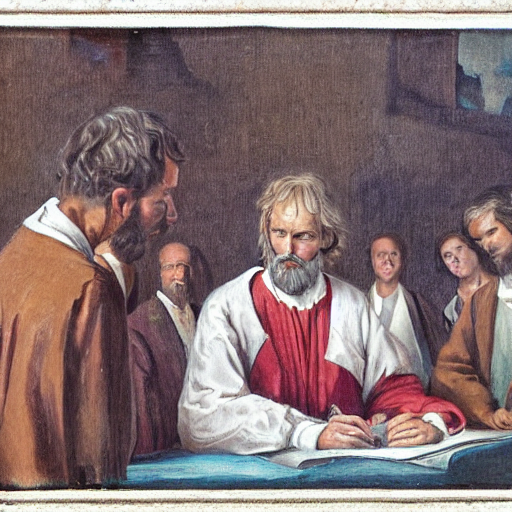

In [8]:
images[0]